# 4-1. 들어가며
![1](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-2-P-1.max-800x600.jpg)  

이번 시간에는 augmentation 기법을 적용해 ResNet-50을 학습시켜 보도록 하겠습니다. 텐서플로우의 랜덤 augmentation API를 사용해 보고, 최신 augmentation 기법을 익힌 뒤, 훈련 데이터셋의 augmentation 적용 여부에 따라 모델의 성능이 달라지는지 비교해 보겠습니다.  

## 실습 목표
***
1. Augmentation을 모델 학습에 적용하기  
2. Augmentation의 적용을 통한 학습 효과 확인하기  
3. 최신 data augmentation 기법 구현 및 활용하기  

## 학습 내용
***
1. Augmentation 적용 (1) 데이터 불러오기  
2. Augmentation 적용 (2) Augmentation 적용하기  
3. Augmentation 적용 (3) 비교 실험하기  
4. 심화 기법 (1) Cutmix Augmentation  
5. 심화 기법 (2) Mixup Augmentation  
6. 프로젝트: CutMix 또는 Mixup 비교실험하기  

## 준비물
***
`~/aiffel/data_augmentation` 폴더가 필요합니다. 아직 디렉토리가 없다면 터미널을 열고 개인 실습환경에 맞추어 경로를 변경, 디렉토리를 생성해 주세요.  
$ mkdir -p ~/aiffel/data_augmentation/data

***

# 4-2. Augmentation 적용 (1) 데이터 불러오기

이번 노드에서는 augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠습니다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 오셨을 것입니다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다. 먼저 필요한 라이브러리들을 불러와 줍니다.  

`tensorflow_datasets`가 설치되어 있지 않다면, 아래 명령어로 설치해 주세요.  

$ pip install tensorflow_datasets  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

전에는 항상 GPU 환경을 확인해 주세요.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

그리고 사용할 데이터셋을 불러옵니다. 이번 시간에는 `stanford_dogs` 데이터셋을 사용해보도록 합시다. `stanford_dogs` 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.  

데이터를 처음 사용한다면 다운로드 받아야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 당황하지 마시고 잠시 휴식 시간을 가져 보세요. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.  

- [stanford_dogs of Tensorflow datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)  



In [3]:
# import urllib3
# urllib3.disable_warnings()
# (ds_train, ds_test), ds_info = tfds.load(
#     'stanford_dogs',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )

In [4]:
# fig = tfds.show_examples(ds_train, ds_info)

***

# 4-3. Augmentation 적용 (2) Augmentation 적용하기  

## 텐서플로우 Random Augmentation API 사용하기  
***

많은 augmentation 기법들이 있지만 그 중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.  

- `random_brightness()`  
- `random_contrast()`  
- `random_crop()`  
- `random_flip_left_right()`  
- `random_flip_up_down()`  
- `random_hue()`  
- `random_jpeg_quality()`  
- `random_saturation()`  

그럼, Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [5]:
# def normalize_and_resize_img(image, label):
#     """Normalizes images: `uint8` -> `float32`."""
#     image = tf.image.resize(image, [224, 224])
#     return tf.cast(image, tf.float32) / 255., label

이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.   

    def 전처리_함수(image, label):   # 변환할 이미지와 
        # 이미지 변환 로직 적용
        new_image = 이미지_변환(image)
        return new_image, label

이렇게 되면 이미지 변환의 결과로 리턴받은 이미지를 그 다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.  

맨 위에서 언급한 random augmentation들 중에서 `random_flip_left_right()`과 `random_brightness()`를 활용해 보겠습니다. "flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 여기서 상하대칭은 테스트 데이터셋의 이미지를 생각해볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.  

In [6]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     return image,label

오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 `apply_normalize_on_dataset()`로 정의하겠습니다.  
여기서는 `apply_normalize_on_dataset()`를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.  

> 여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요.  
> - [hwiyong님의 TTA(test time augmentation) with 케라스](https://hwiyong.tistory.com/215)  

참고로, 이후에 수행할 비교실험을 위해서 `with_aug` 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.  
- 참고: [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)  


In [7]:
# # 데이터셋(ds)을 가공하는 메인함수
# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
#     ds = ds.map(
#         normalize_and_resize_img,  # 기본적인 전처리 함수 적용
#         num_parallel_calls=2
#     )
#     if not is_test and with_aug:
#         ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.batch(batch_size)
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

## Random Augmentation 직접 구현하기
***
위에서는 미리 구현된 random augmentation을 적용하도록 `augment()` 함수를 작성했습니다. 이번에는 `tf.image`의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 `augment2()` 함수를 작성해보세요.  

In [8]:
# # make random augment function
# def augment2(image,label):
#     image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
#     image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
#     return image, label

***

# 4-4. Augmentation 적용 (3) 비교실험 하기  

이제 비교실험을 해보도록 하겠습니다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.  

아래 코드는 텐서플로우 케라스의 `ResNet50` 중 `imagenet`에 훈련된 모델을 불러옵니다. `include_top`은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [9]:
# num_classes = ds_info.features["label"].num_classes
# resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [10]:
# aug_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

텐서플로우 데이터셋에서 불러온 데이터에 하나는 `apply_normalize_on_dataset()`에서 `with_aug`를 `False`로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.  

In [11]:
# (ds_train, ds_test), ds_info = tfds.load(
#     'stanford_dogs',
#     split=['train', 'test'],
#     as_supervised=True,
#     shuffle_files=True,
#     with_info=True,
# )
# ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
# ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
# ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.  

> 아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.

In [12]:
# #EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

# tf.random.set_seed(2020)
# resnet50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# aug_resnet50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# history_resnet50_no_aug = resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

# history_resnet50_aug = aug_resnet50.fit(
#     ds_train_aug, # augmentation 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

훈련 과정을 시각화 해봅시다.

In [13]:
# plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
# plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
# plt.show()

In [14]:
# plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
# plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
# plt.grid(True)
# plt.ylim(0.72, 0.76)
# plt.show()

참고로, `EPOCH=20`으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같습니다. Aumentation을 적용한 경우가 보다 천천히 학습되지만, EPOCH 10을 전후해서 `aug_resnet50`의 accuracy가 더 높게 형성되는 것을 확인할 수 있습니다.  

![2](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-2-P-result02.png)

***

# 4-5. 심화 기법 (1) Cutmix Augmentation  

지금부터 조금 더 복잡한 augmentation 방법을 알아보겠습니다. 첫 번째는 **CutMix augmentation**입니다.  
> 주요 참고 자료
> - [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)  
> - [Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)  

*CutMix*는 네이버 클로바(CLOVA)에서 발표한 *CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features*에서 제안된 방법입니다. 이름인 *CutMix*를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.  

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. *Mixup*은 특정 비율로 픽셀별 값을 섞는 방식이고, *Cutout*은 이미지를 잘라내는 방식입니다.  *CutMix*는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 차에 비유하면 블렌딩 같은 방법이죠.  

두 번째 링크인 *Chris Deotte's CutMix and MixUp on GPU/TPU*에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 *CutMix*와 *MixUp*을 확인 할 수 있습니다. 남은 스텝에서 *CutMix*와 *MixUp*을 구현하면서 참고하도록 합시다. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋습니다.  

*CutMix*는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 이제 한 부분씩 구현해 보겠습니다.  

![3](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-2-P-2.max-800x600.png)  

## 1)이미지 섞기
***
가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 `tfds`에서 한 장을 뽑아서 사용해 보세요.

In [15]:
# # 삭제 예정
# for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
#     if i == 0:
#         image_a_ = image[0]
#         image_b_ = image[1]
#         label_a_ = label[0]
#         label_b_ = label[1]
#         break
# print(type(image_a_))
# print(type(label_a_))

In [16]:
# import matplotlib.pyplot as plt

# # 데이터셋에서 이미지 2개를 가져옵니다. 
# for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
#     if i == 0:
#         image_a = image[0]
#         image_b = image[1]
#         label_a = label[0]
#         label_b = label[1]
#         image_c = image[2]
#         label_c = label[2]
#         break

# plt.subplot(1,2,1)
# plt.imshow(image_a)

# plt.subplot(1,2,2)
# plt.imshow(image_b)

두 개의 이미지를 얻었습니다.  

이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.  

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.  

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
#     print('image_size_x: ', image_size_x)
#     print('image_size_y: ', image_size_y)
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
#     print('x: ', x)
#     print('y: ', y)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
#     print('width: ', width)
#     print('height: ', height)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
#     print('(xa,ya) = ({},{}), (xb, yb) = ({},{})'.format(xa,ya,xb,yb))
    
    return xa, ya, xb, yb

# xa, ya, xb, yb = get_clip_box(image_a, image_b)
# print(xa, ya, xb, yb)

바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

In [18]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
# plt.imshow(mixed_img.numpy())

In [19]:
# # mix_2_images 함수 print 확인해보기

# image_size_x = image_a.shape[1]
# image_size_y = image_a.shape[0] 
# one = image_a[ya:yb,0:xa,:]
# two = image_b[ya:yb,xa:xb,:]
# three = image_a[ya:yb,xb:image_size_x,:]
# top = image_a[0:ya,:,:]
# bottom = image_a[yb:image_size_y,:,:]

# # plt.figure(figsize=(10,10))

# plt.subplot(1,5,1)
# plt.imshow(one.numpy())

# plt.subplot(1,5,2)
# plt.imshow(two.numpy())

# plt.subplot(1,5,3)
# plt.imshow(three.numpy())

# plt.subplot(1,5,4)
# plt.imshow(top.numpy())

# plt.subplot(1,5,5)
# plt.imshow(bottom.numpy())

In [20]:
# middle = tf.concat([one,two,three],axis=1)
# # middel_axis0 = tf.concat([one,two,three],axis=0)

# plt.subplot(1,2,1)
# plt.imshow(middle.numpy())

# # plt.subplot(1,2,2)
# # plt.imshow(middel_axis0.numpy())

## 2)라벨 섞기
***


이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.  

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 `image_a`와 B 클래스를 가진 이미지 `image_b`를 섞을 때 `image_a`를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.  

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.  

In [21]:
# mix two labels
def mix_2_label(image_a, image_b,label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

# mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
# mixed_label

이제 거의다 준비되었습니다.
위에서 구현한 두 함수 `mix_2_images()`과 `mix_2_label()`을 활용하여 배치 단위의 `cutmix()` 함수를 구현해 봅시다.

In [22]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
#         print('for문 동작 시작')
        image_a = image[i]
#         print(type(image_a))
#         print('image_a 생성 완료')
        label_a = label[i]
#         print('label_a 생성 완료')
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))
#     print('for문 동작 완료')
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
#     print('reshape 완료')
#     print(type(mixed_imgs))
#     print(type(mixed_labels))
    return mixed_imgs, mixed_labels

In [23]:
# def test_cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
#     tf.autograph.set_verbosity(0)
#     mixed_imgs = []
#     mixed_labels = [] 
#     image_a = image[0]
#     print(type(image_a))
#     print('image_a: ', image_a)
#     print('image_a 생성 완료')
# #     plt.imshow(tf.make_ndarray(image_a))
# #     j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
#     label_a = label[0]
# #     print(type(label_a))
# # #     print(dir(label_a))
# #     print('label 생성 완료')
# #     print('label:',label_a)
# #     image_b = image[1]
# #     print(type(image_b))
# #     print('image_b 생성 완료')
# #     laebl_b = label[1]
# #     print(type(laebl_b))
# #     print('laebl_b 생성 완료')
    
# #     xa, ya, xb, yb = get_clip_box(image_a, image_b)
# #     mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
# #     mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    
# #     mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
# #     mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
#     return image_a

In [24]:
tf.autograph.set_verbosity(0)

***

# 4-6. 심화 기법 (2) Mixup Augmentation  
> *주요 참고 자료*
> - [*Mixup*: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) 


*Mixup* 은 위에서 보여드린 *Cutmix* 보다 간단하게 이미지와 라벨을 섞어줍니다. *Mixup*: Beyond Empirical Risk Minimization은 위에서 본 *Cutmix* 비교 표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 *Cutmix* 보다 구현이 간단하다고 볼 수 있습니다. 아래에서 직접 *Mixup* 함수를 구현해보세요!  

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.  

![3](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-2-P-3.max-800x600.png)  

In [25]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

# mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
# plt.imshow(mixed_img.numpy())
# print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

In [26]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
#         plt.imshow(image_a)
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

***

# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.  

이번에는 최신 기법(*CutMix* 또는 *Mixup*)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지마세요!  


## 1. Augmentation을 적용한 데이터셋 만들기  
***
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.  

> Q1. 아래는 CutMix를 적용할 수 있도록 변경한 `apply_normalize_on_dataset()`입니다. `batch()` 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?  
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [27]:
def onehot(image, label):
    num_classes = 120
#     onehot_label = [0]*num_classes
    onehot_label = tf.one_hot(label, num_classes)
#     onehot_label[label] = 1
# tf.reshape(tf.stack(onehot_label), (1920,))
    return image, onehot_label

In [28]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. 모델 만들기
***
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.  

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [30]:
# 1. No augmentation

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [31]:
# 2. 기본 Augmentation

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [32]:
# 3. 기본 + CutMix 적용

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [33]:
# 4. 기본 + Mixup

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [34]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## 3. 모델 훈련하기
***
모델을 훈련시켜 주세요.  

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 `resnet50`과 `aug_resnet50`을 훈련하는 데 사용했던 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용해주세요!  

> Q3. `sparse_categorical_crossentropy()`를 사용하지 못하는 이유는 뭘까요?


In [35]:
EPOCH = 40

tf.random.set_seed(2020)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)
cutmix_resnet50.summary()

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
mixup_resnet50.summary()

print('cutmix 학습 시작')
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('cutmix 학습 종료')

print('mixup 학습 시작')
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('mixup 학습 종료')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
________________________________________________________________

Epoch 8/40
750/750 [==============================] - 112s 149ms/step - loss: 2.0679 - accuracy: 0.7795 - val_loss: 1.2129 - val_accuracy: 0.6784
Epoch 9/40
750/750 [==============================] - 112s 149ms/step - loss: 1.9828 - accuracy: 0.8047 - val_loss: 1.1832 - val_accuracy: 0.6793
Epoch 10/40
750/750 [==============================] - 112s 149ms/step - loss: 1.9497 - accuracy: 0.8139 - val_loss: 1.2575 - val_accuracy: 0.6586
Epoch 11/40
750/750 [==============================] - 112s 149ms/step - loss: 1.9501 - accuracy: 0.8150 - val_loss: 1.2595 - val_accuracy: 0.6697
Epoch 12/40
750/750 [==============================] - 112s 149ms/step - loss: 1.9156 - accuracy: 0.8321 - val_loss: 1.3111 - val_accuracy: 0.6538
Epoch 13/40
750/750 [==============================] - 112s 149ms/step - loss: 1.8648 - accuracy: 0.8348 - val_loss: 1.2711 - val_accuracy: 0.6680
Epoch 14/40
750/750 [==============================] - 112s 149ms/step - loss: 1.8408 - accuracy: 0.8441 - val_loss: 1.3

In [36]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 40


resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
resnet50.summary()

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
aug_resnet50.summary()

print('no_aug 학습 시작')
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('no_aug 학습 끝')

print('no_aug 학습 시작')
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('no_aug 학습 끝')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


Epoch 8/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0424 - accuracy: 0.9934 - val_loss: 0.9596 - val_accuracy: 0.7375
Epoch 9/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0349 - accuracy: 0.9963 - val_loss: 0.9816 - val_accuracy: 0.7360
Epoch 10/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0261 - accuracy: 0.9976 - val_loss: 0.9584 - val_accuracy: 0.7471
Epoch 11/40
750/750 [==============================] - 109s 146ms/step - loss: 0.0233 - accuracy: 0.9973 - val_loss: 0.9824 - val_accuracy: 0.7437
Epoch 12/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0174 - accuracy: 0.9986 - val_loss: 0.9558 - val_accuracy: 0.7464
Epoch 13/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0184 - accuracy: 0.9976 - val_loss: 0.9833 - val_accuracy: 0.7450
Epoch 14/40
750/750 [==============================] - 109s 145ms/step - loss: 0.0127 - accuracy: 0.9987 - val_loss: 1.0

## 4. 훈련 과정 시각화하기
***
훈련 과정의 히스토리를 그래프로 시각화해 주세요.  

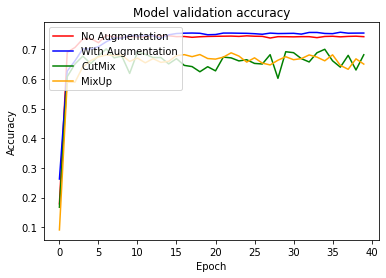

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.show()


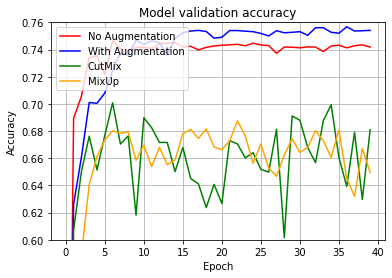

In [41]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()


## 5. Augmentation에 의한 모델 성능 비교  
***
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

1. 위 그래프를 통해 가장 성능이 좋은 모델은 Augmentation을 적용한 모델  
2. cutmix, mixup 등의 기법은 예상 외로 낮은 성능을 보임.  

***

# 루브릭 평가

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---:|:---:|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|


# 회고
1. Going Deeper Project는 Exploration과는 난이도가 사뭇 달랐다.  
2. 깊게 파고드는 노드인 만큼 코드를 하나하나 해부했다.  
3. `이혜성(a.k.a 히비스서커스)님` 주말을 불태우며 하나하나 디버깅했다(총 6시간)  
4. 그 중에서 오타를 발견했는데 아래에 남겨본다. 하나는 노드 본문 내용이고 하나는 코드 내용이다....(이거 찾는데도 꽤 걸렸다)  

- 1) cutmix의 리턴값이 mixed_label가 아닌 mixed_labels가 되어야 합니다.  
- 2) cutmix 함수 설명 중 '위에서 구현한 두 함수 `mix_2_label()`과 `mix_2_label()`을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.' 이 부분에서 첫 번째 `mix_2_label()`가 아닌 `mix_2_images()`가 되어야 합니다.  

5. 또한 onehot 함수를 만드는 일도 새로운 경험이었다. 노드에서 주어진 코드에서 `onehot`이라는 함수 이름만 주고 정의가 되어 있지 않아 당황했는데 해석한 결과는 **'기본상태와 augmentation이 적용된 상태에 라벨의 형태를 onehot벡터로 변경해줘야 한다'**라는 것.  
- 왜냐하면 cutmix, mixup 함수에서 라벨이 onehot벡터 형태로 바뀌기 때문.  
6. tf.one_hot을 이용해 생각보다 간단하게 만들 수 있었다. 사용 예시는 아래와 같다.(아래 코드 참고)  
- tf.one_hot(요소 개수, 표현하고자 하는 길이) -> 만약 tf.one_hot(3,4)라면 [0,0,0,1] 이렇게 표현. 인덱스 번호 3에 1이 있는 것을 알 수 있다. 나는 tf.one_hot(클래스 번호, 클래스 전체 크기)로 정의해 onehot벡터를 만들었다.  
7. 데이터셋 만드는 함수도 간단하게 if 문을 활용해 with_mixup을 적용할 수 있었다. 나중에 활용하면 좋을듯?  
8. 확실히 주어진 코드를 그대로 쓰는게 아니라 확실히 이해하고 하나하나 다 튜닝하다보니 이해는 확 되었다. 그래도 고통받은 받은만큼 남는게 있어서 다행이다!

In [39]:
# tf.onehot 사용 예시

indices = 3
depth = 4
print(tf.one_hot(indices, depth))  # output: [3 x 3]

tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
